In [1]:
import sys
sys.executable

'/home/ubuntu/anaconda3/bin/python'

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import os, sys
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# from sklearn.externals import joblib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# multiprocessing
from joblib import Parallel, delayed

root = r"/home/ubuntu/Documents/RCE" 
data_save_path = os.path.join(root,"data")
os.makedirs(data_save_path, exist_ok=True)
plot_save_path = os.path.join(root,"plot")
os.makedirs(plot_save_path, exist_ok=True)
model_save_path = os.path.join(root,"model")
os.makedirs(plot_save_path, exist_ok=True)
    

def plotCap(data,colname,pctile=[5,10,25,50,75,90,95]):
    pctval = np.nanpercentile(data[colname],pctile)
    plt.bar(x=pctile,height=pctval)
    plt.show()
    
    
def capOutlierVals(data, colname, pctile):
    pctval = np.nanpercentile(data[colname], pctile)
    print(pctval)
    print(f'########### {colname} ###########')
    print("Before Capping - Statistics")
    percentile=[5,10,25,50,75,80,85,90,95,97,98,99]
    tmp_before = pd.DataFrame(np.nanpercentile(data[colname],percentile).reshape(-1,len(percentile)),
                               columns=[str(i)+'%' for i in percentile],index= ['Percentile'])
    print(tmp_before.T)
    print(data[colname].describe())
    # print(stats.describe(data[colname].values, nan_policy="omit"))
    
    print(f'########### {colname} ###########')
    print("After Capping - Statistics")
    
    new_colname =colname+"_cap"
    data[new_colname] = np.where(data[colname] >= pctval, pctval, data[colname])
    tmp_after = pd.DataFrame(np.nanpercentile(data[new_colname],percentile).reshape(-1,len(percentile)),
                              columns=[str(i)+'%' for i in percentile],index= ['Percentile'])
    print(tmp_after.T)
    print(data[new_colname].describe())
    # print(stats.describe(res.values, nan_policy="omit"))  

def print_null(dt):
    print("###########################################################")
    print("shape: ", {dt.shape})
    null_list = dt.isnull().sum(axis=0)
    res = null_list[null_list != 0].to_frame()
    res["null"] = res[0] 
    res = res.drop(0,axis=1)
    res["null_ratio"] = res["null"]/dt.shape[0]
    print(res)
    return res

def print_type(dt):
    print("###########################################################")
    for i in range(dt.shape[1]):
        print(dt.columns[i],type(dt.iloc[0,i]),dt.iloc[0,i],sep="\t")


# self-defined VIF test
def VIFtest(df):
    """
    This function will use the package of statsmodels to perform the variance_inflation_factor, then return the
    result of VIF_value in the form of DataFrame
    Parameters
    ----------
    df: pandas.Dataframe
        data of features

    Returns
    ----------
    res: pandas.DataFrame
        data of the result of VIF test
    """
    # add the constant term
    # ---------------------
    # way 1
    X = add_constant(df)
    
    # way 2 patsy
    """
    features = "+".join(df.columns)
    y, X = dmatrices('df.columns[0] ~' + features, df, return_type='dataframe')
    """
    
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif.round(5)


def checkVIF(x):
    df = add_constant(x)
    df['c'] = 1
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})
    # VIF = VIF.drop('c',axis = 0)
    max_VIF = max(VIF_list)
    print(max_VIF)
    return VIF

def univariate_regress(dt, y):
    for i in dt.columns:
        x = add_constant(dt[i])
        model = sm.OLS(y,x)
        res = model.fit()
        print(res.summary())

def calc(data):
    n=len(data) # 10000个数
    niu=0.0 # niu表示平均值,即期望.
    niu2=0.0 # niu2表示平方的平均值
    niu3=0.0 # niu3表示三次方的平均值
    for a in data:
        niu += a
        niu2 += a**2
        niu3 += a**3
    niu /= n  
    niu2 /= n
    niu3 /= n
    sigma = np.sqrt(niu2 - niu*niu)
    return [niu,sigma,niu3]

def calc_stat(data):
    [niu, sigma, niu3]=calc(data)
    n=len(data)
    niu4=0.0 # niu4计算峰度计算公式的分子
    for a in data:
        a -= niu
        niu4 += a**4
    niu4 /= n
 
    skew =(niu3 -3*niu*sigma**2-niu**3)/(sigma**3) # 偏度计算公式
    kurt=niu4/(sigma**4) - 3 # 峰度计算公式:下方为方差的平方即为标准差的四次方
    return [niu, sigma,skew,kurt]

def show_dist(data):
    sns.distplot(data, fit=stats.norm)
    # (mu0,sigma0) = norm.fit(Sale_AV["Price_1000s_cap"])
    # print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu0, sigma0))
    (mu, sigma, skewness, kurtosis) = calc_stat(data)
    print( '\n mu = {:.2f}, sigma = {:.2f}, skewness={:.2f}, kurtosis = {:.2f}\n'.format(mu, sigma, skewness, kurtosis))
    plt.legend(['Normal dist. ($\mu=$ {:.2f},$\sigma=$ {:.2f}\nSkewness={:.2f}, Kurtosis = {:.2f} )'.format(mu, sigma,skewness, kurtosis)],
               loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution')
    plt.show()

def customized_preprocessing(dt, output, numerical, categorical):
    # check nan of numerical features before preprocessing
    print_null(dt.loc[:,numerical])
    print_null(dt.loc[:,categorical])
    
    # one hot encoding
    X = pd.concat([dt.loc[:,numerical_features], pd.get_dummies(dt.loc[:,categorical_features])],axis=1)
    
    # split data set
    X_train, X_test, Y_train, Y_test = train_test_split(X, dt.loc[:,output])
    
    # z-score normalization
    train_sample_mean = X_train.loc[:,numerical_features].mean(axis=0)
    train_sample_std = X_train.loc[:,numerical_features].std(axis=0) 
    X_train.loc[:,numerical_features] = (X_train.loc[:,numerical_features] - train_sample_mean)/train_sample_std
    X_test.loc[:,numerical_features] = (X_test.loc[:,numerical_features] - train_sample_mean)/train_sample_std  
    return X_train, X_test, Y_train, Y_test


/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1.Feature selection

In [172]:
Sale_AV = pd.read_csv(data_save_path+"/Sale_AV.csv", header=0)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [173]:
Sale_AV.columns

Index(['MD_GeoCounty', 'MD_City', 'MD_Zip', 'Geo_CensusTract',
       'Geo_CensusBlock', 'AreaGrp2', 'LotSize', 'YrB_Grps_20', 'SaleYr',
       'poolGrp1', 'MD_Address', 'MD_Address2', 'MD_Suite', 'MD_State',
       'MD_Latitude', 'MD_Longitude', 'Z_T', 'Z_T_B', 'PropString',
       'LandString', 'PropertyType', 'PropType', 'Year_Built', 'SaleYrGrp',
       'Price', 'PriceGrp', 'Price_Adj', 'PriceAdjGrp', 'LandValue',
       'ImprovValue', 'AssessValue', 'AssessValueGrp', 'AssessValueGrp1',
       'LandtoAssess', 'LandtoPriceAdj', 'ImprovtoAssess', 'ImprovtoPriceAdj',
       'LotSizeGrp', 'garagetype', 'garagespaces', 'extwalls', 'stories',
       'baths', 'bedroomCnt', 'AreaGrp1', 'YrB_Decades', 'YrB_Grps',
       'cap_20PCT_Land', 'building_area', 'lot_size_or_area_sqft',
       'no_of_stories', 'number_of_bedrooms', 'number_of_baths_100',
       'garage_parking_number_of_cars', 'garage_type_parking',
       'exterior_walls', 'Cohort', 'Price_1000s', 'SaleYrChr', 'Price_cap',
       

In [174]:
print_null(Sale_AV)

###########################################################
shape:  {(2858269, 90)}
                                  null  null_ratio
Geo_CensusTract                   3557    0.001244
Geo_CensusBlock                   3557    0.001244
MD_Address2                    2858269    1.000000
MD_Suite                       2847924    0.996381
no_of_stories                   740142    0.258948
number_of_bedrooms                   3    0.000001
number_of_baths_100                  4    0.000001
garage_parking_number_of_cars       18    0.000006
garage_type_parking             451934    0.158115


,null,null_ratio
Geo_CensusTract,3557,0.001244
Geo_CensusBlock,3557,0.001244
MD_Address2,2858269,1.000000
MD_Suite,2847924,0.996381
no_of_stories,740142,0.258948
number_of_bedrooms,3,0.000001
number_of_baths_100,4,0.000001
garage_parking_number_of_cars,18,0.000006
garage_type_parking,451934,0.158115


In [175]:
# percentile of Price
percentile = [10,25,50,75,90,95,96,97,98,99,99.9]
pd.DataFrame(np.nanpercentile(Sale_AV["Price_1000s"],percentile).reshape(-1,len(percentile)),
                               columns=[str(i)+'%' for i in percentile],index= ['Percentile'])

# outlier for price
out = Sale_AV[Sale_AV["Price_1000s"]>2600]
d = {"building_area":[out.building_area.mean(),Sale_AV.building_area.mean()],
     "MeanAVperSF_wt1":[out.MeanAVperSF_wt1.mean(),Sale_AV.MeanAVperSF_wt1.mean()],
     "bedroom":[out.number_of_bedrooms.mean(),Sale_AV.number_of_bedrooms.mean()],
     "baths":[out.number_of_baths_100.mean(),Sale_AV.number_of_baths_100.mean()],
     "no_of_car":[out.garage_parking_number_of_cars.mean(),Sale_AV.number_of_baths_100.mean()],
    }
pd.DataFrame(d,index=["99%","Sale_AV"])   
     

,building_area,MeanAVperSF_wt1,bedroom,baths,no_of_car
99%,4548.666068,662.82385,4.323159,4.289882,1.862016
Sale_AV,2021.021370,323.82512,3.441128,2.306313,2.306313


In [176]:
# Outliers of lot size
# lot size < building area # 2830592 * 28
Sale_AV = Sale_AV[Sale_AV["lot_size_or_area_sqft"] > Sale_AV["building_area"]] # delete 26528

In [187]:
Sale_AV["LotSize"].value_counts()

A. [0-0.249 AC]       2232419
B. [0.25-0.499 AC]     347073
C. [0.50-0.999 AC]      98838
E. [2.00-4.999 AC]      61665
D. [1.00-1.999 AC]      48829
F. [5+ AC]              41768
Name: LotSize, dtype: int64

In [178]:
# percentile of MeanAVperSF_wt1
percentile = [10,25,50,75,90,95,96,97,98,99,99.9]
pd.DataFrame(np.nanpercentile(Sale_AV["MeanAVperSF_wt1"],percentile).reshape(-1,len(percentile)),
                               columns=[str(i)+'%' for i in percentile],index= ['Percentile'])

,10%,25%,50%,75%,90%,95%,96%,97%,98%,99%,99.9%
Percentile,158.3337,207.1251,297.8024,389.2558,530.164959,630.8573,662.9244,701.228,747.6808,822.9786,1021.419


In [198]:
# outliers of bedroom
Sale_AV["number_of_bedrooms"] = Sale_AV["number_of_bedrooms"].fillna(Sale_AV["number_of_bedrooms"].median())
percentile = [1,10,25,50,75,90,95,96,97,98,99,99.9]
pd.DataFrame(np.nanpercentile(Sale_AV["number_of_bedrooms"],percentile).reshape(-1,len(percentile)),
                               columns=[str(i)+'%' for i in percentile],index= ['Percentile'])


,1%,10%,25%,50%,75%,90%,95%,96%,97%,98%,99%,99.9%
Percentile,1.0,2.0,3.0,3.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [180]:
Sale_AV["number_of_bedrooms"]= np.where(Sale_AV["number_of_bedrooms"] > 5, 5 , Sale_AV["number_of_bedrooms"])

In [197]:
# percentile of number_of_baths_100
Sale_AV["number_of_baths_100"] = Sale_AV["number_of_baths_100"].fillna(Sale_AV["number_of_baths_100"].median())
percentile = [1,10,25,50,75,90,95,96,97,98,99,99.9]
pd.DataFrame(np.nanpercentile(Sale_AV["number_of_baths_100"],percentile).reshape(-1,len(percentile)),
                               columns=[str(i)+'%' for i in percentile],index= ['Percentile'])


,1%,10%,25%,50%,75%,90%,95%,96%,97%,98%,99%,99.9%
Percentile,1.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,4.0,4.5,5.0,5.0


In [188]:
Sale_AV["number_of_baths_100"]= np.where(Sale_AV["number_of_baths_100"] > 5, 5 , Sale_AV["number_of_baths_100"])

In [189]:
Sale_AV["baths"].value_counts()

B. [2]       1619289
C. [3]        643153
A. [1]        378770
D. [4+]       188901
E. [NULL]        479
Name: baths, dtype: int64

In [190]:
(Sale_AV["number_of_baths_100"]>=4).sum()

177938

In [196]:
# percentile of garage_parking_number_of_cars
Sale_AV["garage_parking_number_of_cars"] = Sale_AV["garage_parking_number_of_cars"].fillna(Sale_AV["garage_parking_number_of_cars"].median())
percentile = [1,10,25,50,75,90,95,96,97,98,99,99.9]
pd.DataFrame(np.nanpercentile(Sale_AV["garage_parking_number_of_cars"],percentile).reshape(-1,len(percentile)),
                               columns=[str(i)+'%' for i in percentile],index= ['Percentile'])



,1%,10%,25%,50%,75%,90%,95%,96%,97%,98%,99%,99.9%
Percentile,0.0,0.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0


In [186]:
Sale_AV["garagespaces"].value_counts()

B. [2]       1630435
F. [NULL]     670906
A. [1]        265344
C. [3]        202311
D. [4]         45935
E. [5+]        15661
Name: garagespaces, dtype: int64

In [194]:
Sale_AV["garage_parking_number_of_cars"]= np.where(Sale_AV["garage_parking_number_of_cars"] > 4, 4 , Sale_AV["garage_parking_number_of_cars"])

599.1976571347092 740142
533.2818645509391 1326986
627.0356540100697 733004
1194.2780970484698 18465
1047.2110888501743 1148
2323.74 25
6670.7 10


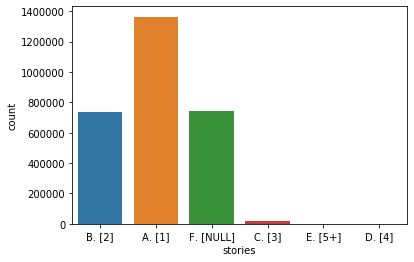

In [163]:
# no_of_stories
print(Sale_AV["Price_1000s"][Sale_AV["no_of_stories"].isna()].mean(),Sale_AV["no_of_stories"].isna().sum())
print(Sale_AV["Price_1000s"][Sale_AV["no_of_stories"]==1].mean(),(Sale_AV["no_of_stories"]==1).sum())
print(Sale_AV["Price_1000s"][Sale_AV["no_of_stories"]==2].mean(),(Sale_AV["no_of_stories"]==2).sum())
print(Sale_AV["Price_1000s"][Sale_AV["no_of_stories"]==3].mean(),(Sale_AV["no_of_stories"]==3).sum())
print(Sale_AV["Price_1000s"][Sale_AV["no_of_stories"]==4].mean(),(Sale_AV["no_of_stories"]==4).sum())
print(Sale_AV["Price_1000s"][Sale_AV["no_of_stories"]==5].mean(),(Sale_AV["no_of_stories"]==5).sum())
print(Sale_AV["Price_1000s"][Sale_AV["no_of_stories"]==6].mean(),(Sale_AV["no_of_stories"]==6).sum())
sns.countplot(Sale_AV["stories"])

In [236]:
# stories_adj
Sale_AV["stories_adj"] = np.where((Sale_AV["stories"] == "C. [3]") |
                                  (Sale_AV["stories"] == "D. [4]") |
                                  (Sale_AV["stories"] == "E. [5+]"),
                                 "C.[3+]", Sale_AV["stories"])

In [201]:
# poolGrps - keep
Sale_AV["poolGrp1"].value_counts()

B. [No]     2289960
A. [Yes]     540632
Name: poolGrp1, dtype: int64

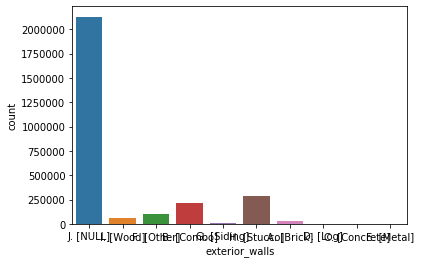

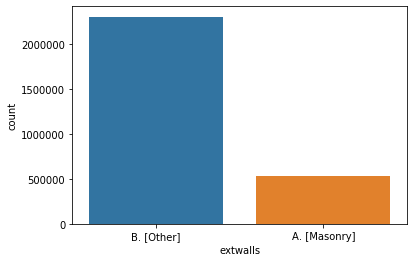

In [207]:
# exterior_walls, extwalls
sns.countplot(Sale_AV["exterior_walls"])
plt.show()
sns.countplot(Sale_AV["extwalls"])
plt.show()

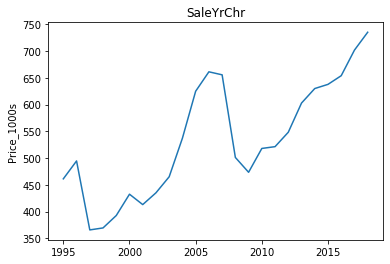

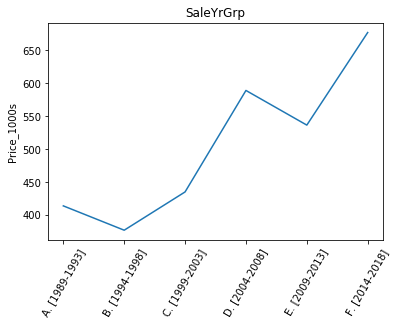

In [231]:
# SaleYr, SaleYrChr, SaleYrGrp
year_ave = Sale_AV.loc[:,["SaleYrChr","Price_1000s"]].groupby("SaleYrChr").mean()
sns.lineplot(year_ave.index.tolist(),year_ave["Price_1000s"])
plt.title("SaleYrChr")
plt.show()
# Sale_AV.loc[:,["SaleYr","Price_1000s"]].groupby("SaleYr").mean()
year_ave2 = Sale_AV.loc[:,["SaleYrGrp","Price_1000s"]].groupby("SaleYrGrp").mean()
sns.lineplot(year_ave2.index.tolist(),year_ave2["Price_1000s"])
plt.xticks(rotation=60)
plt.title("SaleYrGrp")
plt.show()


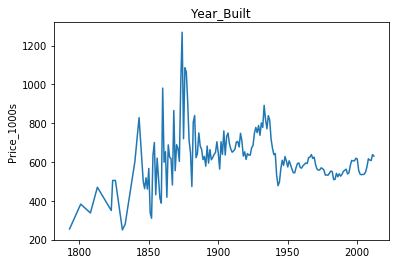

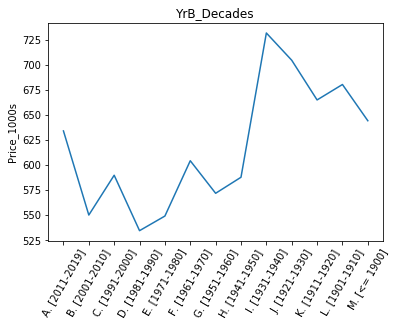

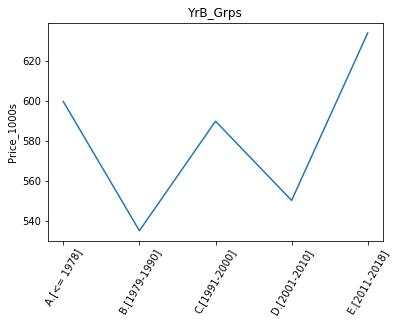

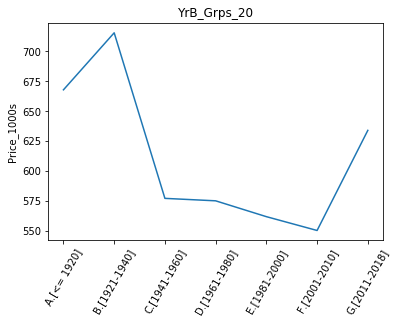

In [230]:
# YrB_Decades', 'YrB_Grps', 'YrB_Grps_20', "Year_Built"
year_ave = Sale_AV.loc[:,["Year_Built","Price_1000s"]].groupby("Year_Built").mean()
sns.lineplot(year_ave.index.tolist(),year_ave["Price_1000s"])
plt.title("Year_Built")
plt.show()

year_ave2 = Sale_AV.loc[:,["YrB_Decades","Price_1000s"]].groupby("YrB_Decades").mean()
sns.lineplot(year_ave2.index.tolist(),year_ave2["Price_1000s"])
plt.xticks(rotation=60)
plt.title("YrB_Decades")
plt.show()

year_ave3 = Sale_AV.loc[:,["YrB_Grps","Price_1000s"]].groupby("YrB_Grps").mean()
sns.lineplot(year_ave3.index.tolist(),year_ave3["Price_1000s"])
plt.xticks(rotation=60)
plt.title("YrB_Grps")
plt.show()

year_ave4 = Sale_AV.loc[:,["YrB_Grps_20","Price_1000s"]].groupby("YrB_Grps_20").mean()
sns.lineplot(year_ave4.index.tolist(),year_ave4["Price_1000s"])
plt.xticks(rotation=60)
plt.title("YrB_Grps_20")
plt.show()


# 2. preprocessing

In [287]:
def customized_preprocessing(dt, output, numerical_features, categorical_features):
    # check nan of numerical features before preprocessing
    print_null(dt.loc[:,numerical])
    print_null(dt.loc[:,categorical])
    
    # one hot encoding
    X = pd.concat([dt.loc[:,numerical_features], pd.get_dummies(dt.loc[:,categorical_features])],axis=1)
    
    # split data set
    X_train, X_test, Y_train, Y_test = train_test_split(X, dt.loc[:,output])
    
    # z-score normalization
    train_sample_mean = X_train.loc[:,numerical_features].mean(axis=0)
    train_sample_std = X_train.loc[:,numerical_features].std(axis=0) 
    X_train.loc[:,numerical_features] = (X_train.loc[:,numerical_features] - train_sample_mean)/train_sample_std
    X_test.loc[:,numerical_features] = (X_test.loc[:,numerical_features] - train_sample_mean)/train_sample_std  
    return X_train, X_test, Y_train, Y_test
Sale_AV["log_Price_1000s_cap"] = np.log(Sale_AV["Price_1000s_cap"])
output = [#"Price_1000s_cap",
         "log_Price_1000s_cap"
         ]
numerical = ["building_area",
             "MeanAVperSF_wt1",
             "lot_size_or_area_sqft",
            "number_of_bedrooms",
            "number_of_baths_100",
            "garage_parking_number_of_cars"]
categorical = ["stories_adj",
               "YrB_Decades",
               "SaleYrGrp",
               #"SaleYrChr", 
               "extwalls",
               "poolGrp1"]

In [273]:
VIFtest(Sale_AV.loc[:,numerical])

,features,VIF Factor
0,const,25.27805
1,building_area,2.07526
2,MeanAVperSF_wt1,1.08450
3,lot_size_or_area_sqft,1.00002
4,number_of_bedrooms,1.70149
5,number_of_baths_100,2.36731
6,garage_parking_number_of_cars,1.15120


In [288]:
X_train,X_test,Y_train,Y_test = customized_preprocessing(Sale_AV,output,numerical,categorical)
print(X_train.shape,X_test.shape)

###########################################################
shape:  {(2830592, 6)}
Empty DataFrame
Columns: [null, null_ratio]
Index: []
###########################################################
shape:  {(2830592, 5)}
Empty DataFrame
Columns: [null, null_ratio]
Index: []
(2122944, 33) (707648, 33)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


# 3.modeling
## A.GLM

In [275]:
from sklearn.linear_model import LinearRegression , Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [276]:
def regression_res(X_train,X_test,Y_train,Y_test):
    # (Price_cap)
    # print("Price:")

    # build the model and fit
    lin_reg = LinearRegression(n_jobs=-1)
    lin_reg.fit(X_train,Y_train)

    # get R_square
    print(f"train_r2: {lin_reg.score(X_train,Y_train)}")
    print(f"test_r2: {lin_reg.score(X_test,Y_test)}")

    # ge predict
    Y_train_pred = lin_reg.predict(X_train)
    Y_test_pred = lin_reg.predict(X_test)

    lin_mse_train = mean_squared_error(y_true=Y_train, y_pred=Y_train_pred)
    lin_mse = mean_squared_error(y_true=Y_test, y_pred=Y_test_pred)
    print(lin_mse_train, lin_mse,sep="\t")

    res = pd.DataFrame(Y_test.copy())
    res["Y_test_pred"] = Y_test_pred
    return res
          
def regression_res_log(X_train,X_test,Y_train,Y_test):
    # (Price_cap)
    # print("Price:")

    # build the model and fit
    lin_reg = LinearRegression(n_jobs=-1)
    lin_reg.fit(X_train,Y_train["log_Price_1000s_cap"])

    # get R_square
    print(f"train_r2: {lin_reg.score(X_train,Y_train['log_Price_1000s_cap'])}")
    print(f"test_r2: {lin_reg.score(X_test,Y_test['log_Price_1000s_cap'])}")

    # ge predict
    Y_train_pred = np.exp(lin_reg.predict(X_train))
    Y_test_pred = np.exp(lin_reg.predict(X_test))

    lin_mse_train = mean_squared_error(y_true=Y_train["log_Price_1000s_cap"], y_pred=Y_train_pred)
    lin_mse = mean_squared_error(y_true=Y_test["log_Price_1000s_cap"], y_pred=Y_test_pred)
    print(lin_mse_train, lin_mse,sep="\t")

    res = pd.DataFrame(Y_test["log_Price_1000s_cap"].copy())
    res["Y_test_pred"] = Y_test_pred
    return res

    


In [289]:
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_train,Y_train)

# get R_square
print(f"train_r2: {lin_reg.score(X_train,Y_train)}")
print(f"test_r2: {lin_reg.score(X_test,Y_test)}")

# ge predict
Y_train_pred = lin_reg.predict(X_train)
Y_test_pred = lin_reg.predict(X_test)

lin_mse_train = mean_squared_error(y_true=Y_train, y_pred=Y_train_pred)
lin_mse = mean_squared_error(y_true=Y_test, y_pred=Y_test_pred)
print(lin_mse_train, lin_mse,sep="\t")


train_r2: 0.7715608800213517
test_r2: 0.7863596074886542
0.06853734889600233	0.06418173881463458


In [290]:
Y_pred = pd.Series(Y_test_pred,name="Y_pred")
abs_residuals =  np.abs(- Y_test + Y_test_pred)
abs_residuals.name = "abs_residuals"
accuracy = abs_residuals/ Y_test
accuracy.name ="accuracy"
mape_table = pd.merge(X_test,Y_test,left_index = True, right_index=True,how="inner")
mape_table = pd.merge(mape_table,Y_pred,left_index = True, right_index=True,how="inner")
mape_table = pd.merge(mape_table, abs_residuals, left_index=True,right_index = True, how="inner")
mape_table = pd.merge(mape_table, accuracy, left_index=True,right_index = True, how="inner")

Exception: Data must be 1-dimensional